In [8]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [9]:
import os, pickle
import random
import warnings
warnings.filterwarnings("ignore")

In [10]:
ts_configs = [
    ("Births",       Births,       31),
    ("Temperatures", Temperatures, 5),
]
autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Births (window_size=31)
  Epoch 1/30 — loss: 0.410345
  Epoch 2/30 — loss: 0.124933
  Epoch 3/30 — loss: 0.086050
  Epoch 4/30 — loss: 0.074315
  Epoch 5/30 — loss: 0.068064
  Epoch 6/30 — loss: 0.063669
  Epoch 7/30 — loss: 0.060519
  Epoch 8/30 — loss: 0.058941
  Epoch 9/30 — loss: 0.056515
  Epoch 10/30 — loss: 0.055544
  Epoch 11/30 — loss: 0.054755
  Epoch 12/30 — loss: 0.053495
  Epoch 13/30 — loss: 0.052617
  Epoch 14/30 — loss: 0.052316
  Epoch 15/30 — loss: 0.052033
  Epoch 16/30 — loss: 0.051695
  Epoch 17/30 — loss: 0.051226
  Epoch 18/30 — loss: 0.050997
  Epoch 19/30 — loss: 0.050513
  Epoch 20/30 — loss: 0.050296
  Epoch 21/30 — loss: 0.050442
  Epoch 22/30 — loss: 0.049999
  Epoch 23/30 — loss: 0.049910
  Epoch 24/30 — loss: 0.049645
  Epoch 25/30 — loss: 0.049762
  Epoch 26/30 — loss: 0.049720
  Epoch 27/30 — loss: 0.049615
  Epoch 28/30 — loss: 0.049178
  Epoch 29/30 — loss: 0.049173
  Epoch 30/30 — loss: 0.048989
Saved AE: autoencoders\ae_Births.pth


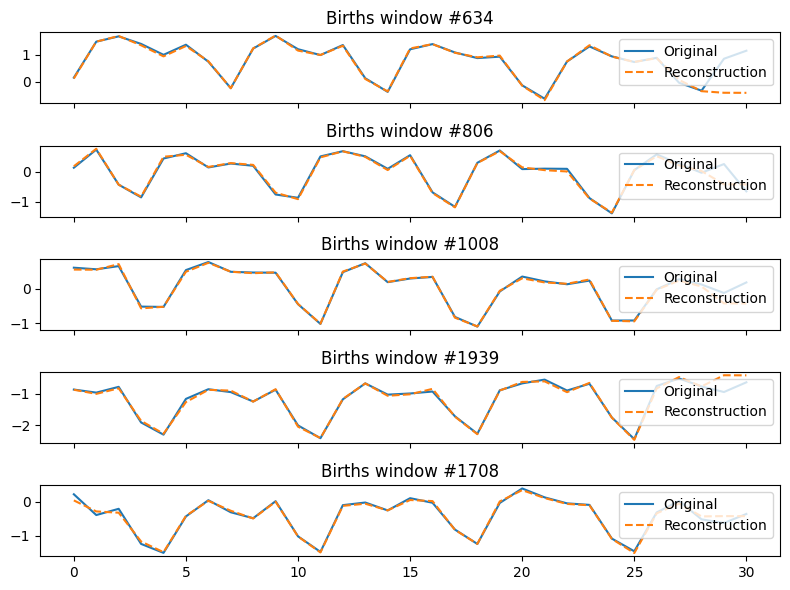


Training AE on Temperatures (window_size=5)
  Epoch 1/30 — loss: 0.867027
  Epoch 2/30 — loss: 0.320330
  Epoch 3/30 — loss: 0.206639
  Epoch 4/30 — loss: 0.166365
  Epoch 5/30 — loss: 0.155699
  Epoch 6/30 — loss: 0.143163
  Epoch 7/30 — loss: 0.100122
  Epoch 8/30 — loss: 0.082466
  Epoch 9/30 — loss: 0.078667
  Epoch 10/30 — loss: 0.076324
  Epoch 11/30 — loss: 0.072477
  Epoch 12/30 — loss: 0.065785
  Epoch 13/30 — loss: 0.050172
  Epoch 14/30 — loss: 0.038868
  Epoch 15/30 — loss: 0.036038
  Epoch 16/30 — loss: 0.035615
  Epoch 17/30 — loss: 0.033261
  Epoch 18/30 — loss: 0.031652
  Epoch 19/30 — loss: 0.031366
  Epoch 20/30 — loss: 0.029095
  Epoch 21/30 — loss: 0.026985
  Epoch 22/30 — loss: 0.023265
  Epoch 23/30 — loss: 0.017939
  Epoch 24/30 — loss: 0.013558
  Epoch 25/30 — loss: 0.010473
  Epoch 26/30 — loss: 0.007171
  Epoch 27/30 — loss: 0.006096
  Epoch 28/30 — loss: 0.005277
  Epoch 29/30 — loss: 0.004406
  Epoch 30/30 — loss: 0.004720
Saved AE: autoencoders\ae_Temperat

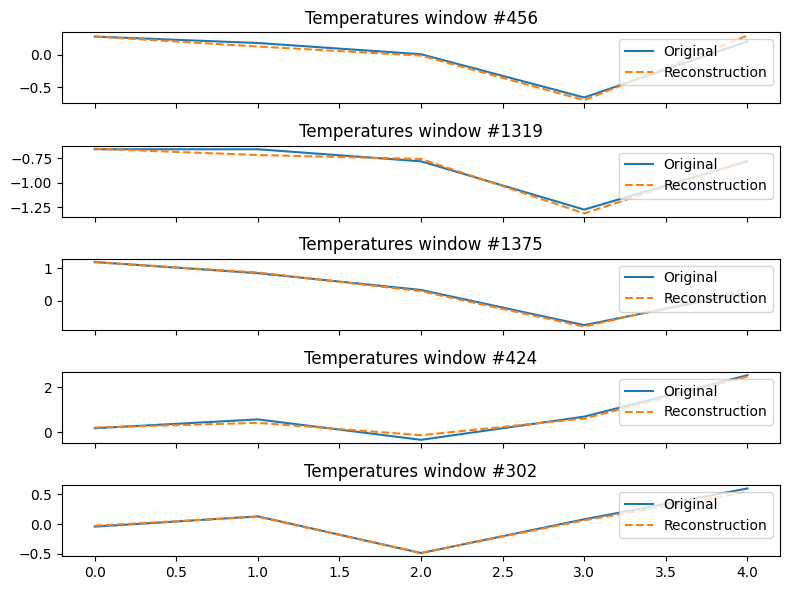

In [11]:
epochs = 30
lr     = 1e-3

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [12]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Births (window_size=31)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Births_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Births_LinearRegression.pkl
    → Training RandomForest… DONE: models\Births_RandomForest.pkl
    → Training SVR… DONE: models\Births_SVR.pkl
    → Training GradientBoosting… DONE: models\Births_GradientBoosting.pkl
    → Training DT… DONE: models\Births_DT.pkl
    → Training MLP… DONE: models\Births_MLP.pkl
    → Training LSTM… 1/30 0.47704 | 15/30 0.06249 | 30/30 0.06510 | DONE: models\Births_LSTM.pkl
    → Training BiLSTM… 1/30 0.40231 | 15/30 0.09534 | 30/30 0.06564 | DONE: models\Births_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.23918 | 15/30 0.08145 | 30/30 0.06775 | DONE: models\Births_CNNLSTM.pkl

→ Dataset: Temperatures (window_size=5)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training Lin

In [13]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA","ExpSmoothing","LinearRegression","RandomForest",
        "SVR","GradientBoosting","DT","MLP","LSTM","BiLSTM","CNNLSTM"
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=31)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_LinearRegression.pkl
     RandomForest loaded from models\Births_RandomForest.pkl
     SVR loaded from models\Births_SVR.pkl
     GradientBoosting loaded from models\Births_GradientBoosting.pkl
     DT loaded from models\Births_DT.pkl
     MLP loaded from models\Births_MLP.pkl
     LSTM loaded from models\Births_LSTM.pkl
     BiLSTM loaded from models\Births_BiLSTM.pkl
     CNNLSTM loaded from models\Births_CNNLSTM.pkl

→ Loading models for Temperatures (window_size=5)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded from

In [14]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Births (window_size=31) ===
RoC sizes
  ARIMA                94 entries
  ExpSmoothing         57 entries
  LinearRegression    204 entries
  RandomForest        175 entries
  SVR                 190 entries
  GradientBoosting    196 entries
  DT                  166 entries
  MLP                 204 entries
  LSTM                167 entries
  BiLSTM              168 entries
  CNNLSTM             174 entries

=== Validation RoC for Temperatures (window_size=5) ===
RoC sizes
  ARIMA               109 entries
  ExpSmoothing         96 entries
  LinearRegression     58 entries
  RandomForest        127 entries
  SVR                  51 entries
  GradientBoosting     54 entries
  DT                  129 entries
  MLP                  46 entries
  LSTM                 42 entries
  BiLSTM               69 entries
  CNNLSTM             126 entries


In [15]:
def compute_distance(win1, win2, metric="euclidean"):
    """
    Compute distance between two windows using the specified metric.

    Parameters:
        win1, win2: numpy.ndarray or torch.Tensor of the same shape
        metric (str): one of "euclidean", "manhattan", or "cosine"

    Returns:
        float: the computed distance
    """
    if type(win1) != type(win2):
        raise TypeError("Both windows must be of the same type (either both NumPy arrays or both PyTorch tensors)")

    if win1.shape != win2.shape:
        raise ValueError(f"Shape mismatch: {win1.shape} vs {win2.shape}")

    # If numpy arrays
    if isinstance(win1, np.ndarray):
        if metric == "euclidean":
            return np.linalg.norm(win1 - win2)
        elif metric == "manhattan":
            return np.sum(np.abs(win1 - win2))
        elif metric == "cosine":
            num = np.dot(win1.flatten(), win2.flatten())
            denom = np.linalg.norm(win1) * np.linalg.norm(win2)
            return 1 - num / denom
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    # If torch tensors
    elif isinstance(win1, torch.Tensor):
        if metric == "euclidean":
            return torch.norm(win1 - win2).item()
        elif metric == "manhattan":
            return torch.sum(torch.abs(win1 - win2)).item()
        elif metric == "cosine":
            return 1 - F.cosine_similarity(win1.flatten(), win2.flatten(), dim=0).item()
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    else:
        raise TypeError("Unsupported input type. Use NumPy arrays or PyTorch tensors.")

In [16]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    # ensure y_true is ndarray
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    for embed in autoencoder_embedding_flags:
        mode = "latent" if embed else "raw"
        for metric in metrics_list:
            preds = []
            for w in X_test:
                # 1) build query
                if embed:
                    with torch.no_grad():
                        q = ae.encode(w).cpu()            # q is a torch.Tensor
                else:
                    q = w                           # q is a np.ndarray

                # 2) nearest‐RoC lookup
                best_name, best_dist = None, float("inf")
                space = "latent" if embed else "raw"
                for name, model in forecasters.items():
                    for entry in model.rocs[space]:
                        if embed: entry.cpu()
                        d = compute_distance(q, entry, metric=metric)
                        if d < best_dist:
                            best_dist, best_name = d, name

                # 3) predict
                preds.append(forecasters[best_name].predict(w))

            # 4) compute & print MSE
            mse = mean_squared_error(y_true, preds)
            print(f"[{mode:^6}]  Metric={metric:<9}  Test MSE: {mse:.6f}")


=== Dataset: Births ===
[ raw  ]  Metric=euclidean  Test MSE: 0.528643
[ raw  ]  Metric=manhattan  Test MSE: 0.531631
[ raw  ]  Metric=cosine     Test MSE: 0.508244
[latent]  Metric=euclidean  Test MSE: 0.503771
[latent]  Metric=manhattan  Test MSE: 0.495996
[latent]  Metric=cosine     Test MSE: 0.509318

=== Dataset: Temperatures ===
[ raw  ]  Metric=euclidean  Test MSE: 0.430341
[ raw  ]  Metric=manhattan  Test MSE: 0.433614
[ raw  ]  Metric=cosine     Test MSE: 0.456678
[latent]  Metric=euclidean  Test MSE: 0.441726
[latent]  Metric=manhattan  Test MSE: 0.446878
[latent]  Metric=cosine     Test MSE: 0.446284
